---

<h1><center>RUL Prediction of Nasa Turbofan Engine - Group 45 <br><br> FD001 Dataset </center></h1>

---

# 0. Background on the Dataset
WRITE STUFF HERE

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

rng_seed = 2434

# 1.1 Load Datasets and Append Target (RUL Series) to Datasets

In [2]:
# Column names from "Damage Propogation Modeling"
column_names = [
    'unit_number', 'time', 
    'altitude', 'machnum','tra',
    'T2', 'T24', 'T30', 'T50', 'P2', 'P15', 'P30',
    'Nf', 'Nc', 'epr', 'Ps30', 'phi', 'NRf', 'NRc',
    'BPR', 'farB', 'htBleed', 'Nf_dmd', 'PCNfR_dmd', 'W31', 'W32'
]

# Load .txt files
raw_train = pd.read_csv('train_FD001.txt', sep='\s+', header=None, names=column_names)
raw_test = pd.read_csv('test_FD001.txt', sep='\s+', header=None, names=column_names)
true_RUL = pd.read_csv('RUL_FD001.txt', sep='\s+', header=None, names=['RUL'])

# 1.2 Compute and Append Target (RUL Series) to Datasets

In [3]:
# Define the variable for the RUL ceiling
RUL_MAX = 105

# Calculate RUL series (target) for each unit ID in training data using failure time 'T_fail'
RUL_series = np.array([])
unique_units = raw_train['unit_number'].unique()
for unit_ID in unique_units:
    unit_data = raw_train[raw_train['unit_number'] == unit_ID].copy()
    T_fail = unit_data['time'].max()
    
    RUL_linear = T_fail - unit_data['time']
    
    # Implement Piecewise RUL
    RUL_series = np.concatenate((RUL_series, np.minimum(RUL_linear, RUL_MAX)),axis=0)
    
raw_train['RUL'] = RUL_series 

# Calculate RUL series for each Unit ID in test data using 'true_RUL'
RUL_series = np.array([])
for index, unit_ID in enumerate(unique_units):
    unit_data = raw_test[raw_test['unit_number'] == unit_ID].copy()
    
    T_last = unit_data['time'].max()
    RUL_last = true_RUL['RUL'][index]
    T_fail = T_last + RUL_last
    
    RUL_linear = T_fail - unit_data['time']
    
    # Implement Piecewise RUL
    RUL_series = np.concatenate((RUL_series, np.minimum(RUL_linear, RUL_MAX)),axis=0)
    
raw_test['RUL'] = RUL_series

# 1.3 Prune Test Data
We are only concerned with predicting RUL for the last cycle of each unit in test data since `RUL_FD001.txt` only gives the true RUL for the last cycle. Thus, all rows before the last cycle are removed.

In [4]:
raw_test = raw_test.groupby('unit_number').last().reset_index()

# 1.4 Inspect and Clean Datasets
Inspect and remove columns from `raw_train` and `raw_test` if they contain Null or NaN values. No such columns were found

In [5]:
# Make copy of data sets
clean_train = raw_train.copy()
clean_test = raw_test.copy()

# Identify if columns have null values
is_null_arr = pd.isnull(clean_train)
col_has_null = np.any(is_null_arr ,axis=0)
drop_null_cols = clean_train.columns[col_has_null]
drop_null_cols

Index([], dtype='object')

In [6]:
# Identify if columns have NaN values
is_nan_arr = pd.isna(clean_train)
col_has_nan = np.any(is_nan_arr, axis=0)
drop_nan_cols = clean_train.columns[col_has_nan]
drop_nan_cols

Index([], dtype='object')

# 1.5 Feature Selection and Defining Input and Output Dataframes
Features are removed based on two rudimentary criteria:
1. Features that are constant across all units are removed because they hold no statistical power
2. If 2 features are highly correlated, they are redundant and one may be removed
+ **Additionally:**
1. The `'unit_number'` feature is merely to partition the time series of different instances of simulated turbofan engines **within the same dataset** which have randomly generated starting healths (efficiency and flow parameters) and degradation trajectorys (parameters of an exponential degradation model) sampled from the same distributions. `'unit_number'=1` in `train_FD001.txt` and `test_FD001.txt` are **different instances** and should not be conflated. Thus, `unit_number` is removed from the datasets to prevent the models from biasing the predictions due to arbitrarily matching unit IDs.
2. The columns representing the operational settings are **known** to be held constant for `FD001` so they are removed

In [7]:
drop_cols = ['unit_number', 'altitude', 'machnum', 'tra'] # Remove settings columns

# Check which sensors have constant/near constant values (arbitrarily defined as less than 3)
unique_count_series = raw_train.nunique()
unique_count_series[unique_count_series == 1]

tra          1
T2           1
P2           1
epr          1
farB         1
Nf_dmd       1
PCNfR_dmd    1
dtype: int64

In [8]:
drop_cols += ['T2', 'P2', 'P15', 'epr', 'farB', 'Nf_dmd', 'PCNfR_dmd']
Xtrain = clean_train.drop(drop_cols + ['RUL'], axis=1)
ytrain = clean_train['RUL']
Xtest = clean_test.drop(drop_cols + ['RUL'], axis=1)
ytest = clean_test['RUL']

# 2 Hyper Parameter Tuning With Gridsearch
Will use `hypersolve()` from lab06 to tune hyperparameters. `plot_grid_results()` from `lab6_utils.py` was modified to plot negative MSE instead of accuracy. 
+ **NOTE:** `scoring='neg_mean_squared_error'` and `refit='neg_mean_squared_error'` arguments passed to `GridSearchCV()` for regression models,

In [9]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from lab6_utils import unpack_gridsearch, plot_grid_result

def hypersolve(model,param_grid):
    # 1. Create the pipeline model
    pipe = Pipeline([
        ('scaler', StandardScaler()),
        ('model', model)
    ])

    # 2. Construct the `GridSearchCV` object as was done in part 5.2
    gs = GridSearchCV(
        estimator=pipe,
        param_grid=param_grid,
        scoring='neg_mean_squared_error',
        cv=3,
        refit='neg_mean_squared_error'
    )
    
    # 3. Run the grid search
    gs = gs.fit(Xtrain,ytrain)
    
    # 4. Run `unpack_gridsearch` to obtain the results dictionary.
    result = unpack_gridsearch(gs)

    # 5. Plot the result with `plot_grid_result`
    plot_grid_result(result)

    # 6. return result
    return result

# 3.1 Train and Fit Random Forest Regressors

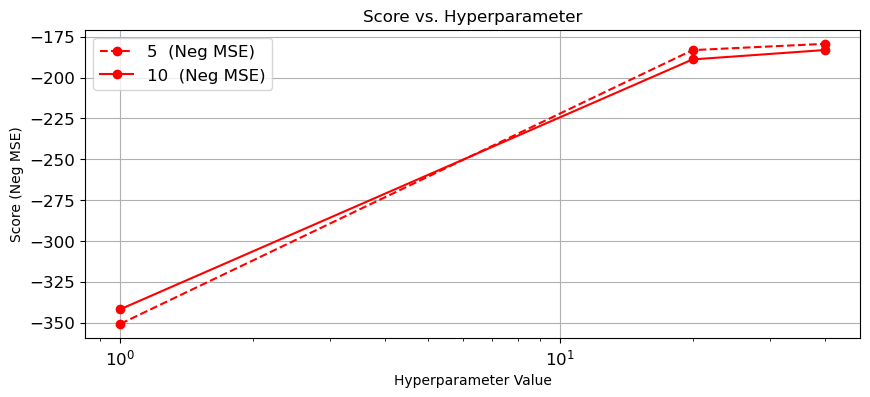

In [10]:
from sklearn.ensemble import RandomForestRegressor

param_grid_rf = {
    'model__max_features' : [5, 10],#len(Xtrain.columns)],
    'model__n_estimators' : [1, 20, 40]
}
model = RandomForestRegressor(random_state=rng_seed)
result_rf = hypersolve(model, param_grid_rf)

In [11]:
result_rf

{'scoregrid': {5:     mean_test_score
  1       -350.621250
  20      -183.180399
  40      -179.326007,
  10:     mean_test_score
  1       -341.680093
  20      -188.880461
  40      -183.122299},
 'best_params': {'model__max_features': 5, 'model__n_estimators': 40},
 'best_estimator': Pipeline(steps=[('scaler', StandardScaler()),
                 ('model',
                  RandomForestRegressor(max_features=5, n_estimators=40,
                                        random_state=2434))]),
 'best_score': np.float64(-179.32600670713975),
 'param_grid': {'model__max_features': [5, 10],
  'model__n_estimators': [1, 20, 40]}}

# 3.2 Predict With Best Random Forest Regressor

In [12]:
best_rf_model = result_rf['best_estimator']
yhat = best_rf_model.predict(Xtest)

from sklearn.metrics import r2_score
r2 = r2_score(ytest, yhat)
r2

0.8512922150961323

# 3.3 Plot Prediction

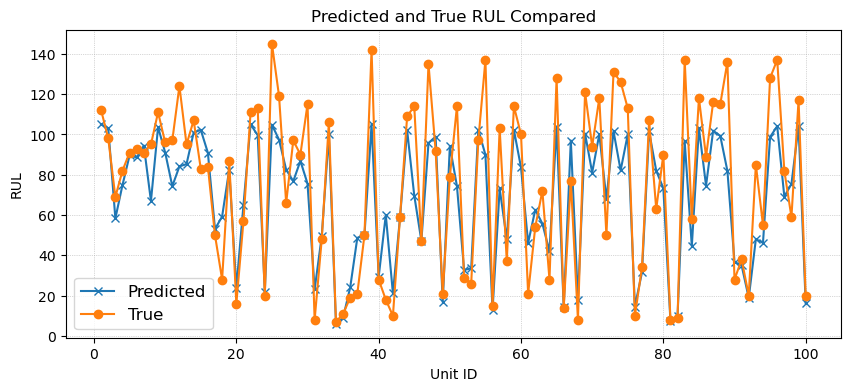

In [13]:
plt.figure(figsize=(10,4))
plt.plot(clean_test['unit_number'], yhat, label='Predicted', marker='x')
plt.plot(clean_test['unit_number'], true_RUL, label = 'True', marker='o')
    
plt.title('Predicted and True RUL Compared')
plt.xlabel('Unit ID')
plt.ylabel('RUL')
plt.legend(fontsize=12)
plt.grid(axis='both', linestyle=':', linewidth=0.5)
plt.show()